In [ ]:
import time
import qiskit
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.visualization.bloch import Bloch
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_histogram

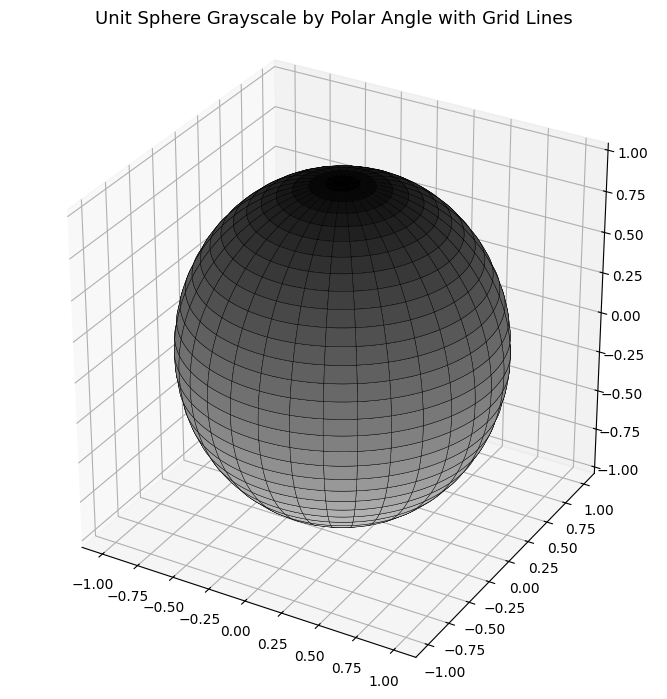

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# θ에 따라 grayscale 할당
def theta_to_grayscale(theta):
    quantized = int((theta / np.pi) * 255)
    return np.clip(quantized, 0, 255)

# 단위 구 데이터 생성 (θ-φ 격자)
def generate_unit_sphere(n_theta=256, n_phi=256):
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    gray_values = np.vectorize(theta_to_grayscale)(theta)
    return x, y, z, gray_values

# 시각화 (격자 라인 포함)
def visualize_sphere_with_grid(x, y, z, gray_values):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    # surface + edge color for grid effect
    surf = ax.plot_surface(
        x, y, z,
        facecolors=plt.cm.gray(gray_values / 255),
        rstride=8, cstride=8,  # θ, φ 간격
        linewidth=0.3,
        edgecolor='k',  # grid line color
        antialiased=True,
        shade=False
    )

    ax.set_box_aspect([1, 1, 1])
    #ax.set_axis_off()
    ax.set_title("Unit Sphere Grayscale by Polar Angle with Grid Lines", fontsize=13)
    plt.tight_layout()
    plt.show()

# 실행
x, y, z, gray_values = generate_unit_sphere()
visualize_sphere_with_grid(x, y, z, gray_values)


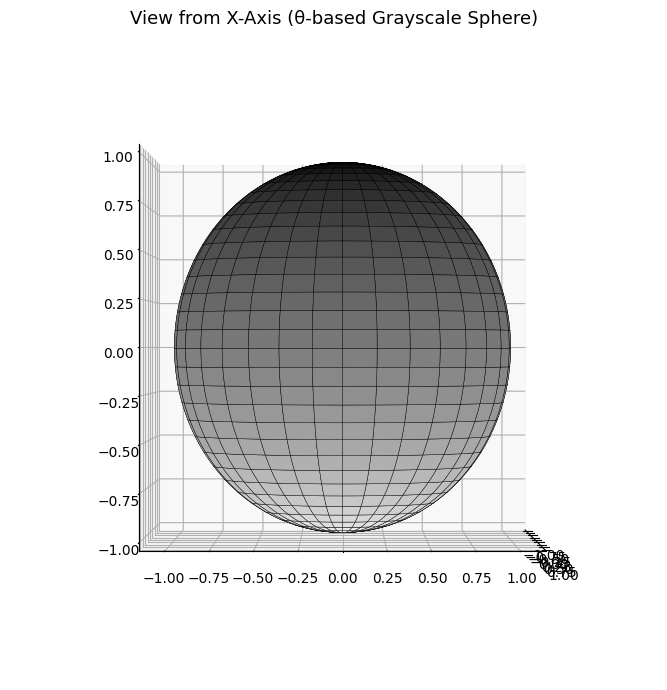

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# θ → grayscale
def theta_to_grayscale(theta):
    quantized = int((theta / np.pi) * 255)
    return np.clip(quantized, 0, 255)

# 단위 구 표면 생성
def generate_unit_sphere(n_theta=256, n_phi=256):
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    gray_values = np.vectorize(theta_to_grayscale)(theta)
    return x, y, z, gray_values

# 시각화 + 시점 x축으로 설정
def visualize_sphere_from_x_axis(x, y, z, gray_values):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        x, y, z,
        facecolors=plt.cm.gray(gray_values / 255),
        rstride=8, cstride=8,
        linewidth=0.3,
        edgecolor='k',
        antialiased=True,
        shade=False
    )

    ax.set_box_aspect([1, 1, 1])
    #ax.set_axis_off()
    ax.view_init(elev=0, azim=0)  # ← 시점을 x축 방향으로 설정
    ax.set_title("View from X-Axis (θ-based Grayscale Sphere)", fontsize=13)
    plt.tight_layout()
    plt.show()

# 실행
x, y, z, gray_values = generate_unit_sphere()
visualize_sphere_from_x_axis(x, y, z, gray_values)


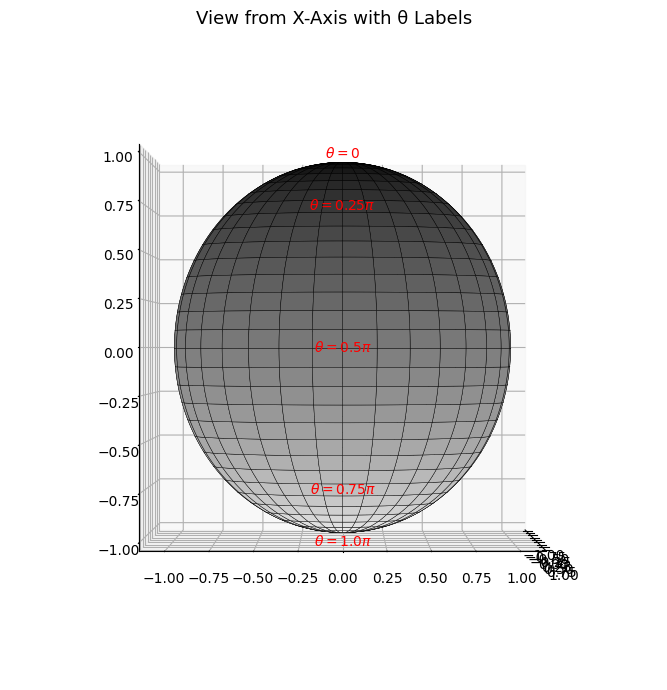

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# θ → grayscale
def theta_to_grayscale(theta):
    quantized = int((theta / np.pi) * 255)
    return np.clip(quantized, 0, 255)

# 구 데이터 생성
def generate_unit_sphere(n_theta=256, n_phi=256):
    theta = np.linspace(0, np.pi, n_theta)
    phi = np.linspace(0, 2 * np.pi, n_phi)
    theta, phi = np.meshgrid(theta, phi)

    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    gray_values = np.vectorize(theta_to_grayscale)(theta)
    return x, y, z, gray_values

# θ 라벨을 구 표면에 표시
def add_theta_labels(ax, radius=1.05):
    label_thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
    for theta in label_thetas:
        x = radius * np.sin(theta)
        y = 0  # φ = 0 방향 (xz 평면)
        z = radius * np.cos(theta)
        label = f"$\\theta = {round(theta/np.pi, 2)}\\pi$" if theta != 0 else r"$\theta = 0$"
        ax.text(x, y, z, label, color='red', fontsize=10, ha='center', va='center')

# 시각화 + θ 라벨 + x축 시점
def visualize_sphere_from_x_axis_with_labels(x, y, z, gray_values):
    fig = plt.figure(figsize=(9, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(
        x, y, z,
        facecolors=plt.cm.gray(gray_values / 255),
        rstride=8, cstride=8,
        linewidth=0.3,
        edgecolor='k',
        antialiased=True,
        shade=False
    )

    ax.set_box_aspect([1, 1, 1])
    #ax.set_axis_off()
    ax.view_init(elev=0, azim=0)  # x축 방향 시점
    ax.set_title("View from X-Axis with θ Labels", fontsize=13)

    # θ 라벨 추가
    add_theta_labels(ax)

    plt.tight_layout()
    plt.show()

# 실행
x, y, z, gray_values = generate_unit_sphere()
visualize_sphere_from_x_axis_with_labels(x, y, z, gray_values)


In [ ]:
import numpy as np
import pandas as pd

# θ 구간: 0~π 까지를 255등분 (총 255 구간, 256 경계점)
theta_bins_rad = np.linspace(0, np.pi, 256)
theta_bins_deg = np.degrees(theta_bins_rad)

# 각 θ 구간에 대해 대응되는 grayscale 값 정의 (0~254 구간 → grayscale = 구간 인덱스)
lookup_table = []

for i in range(255):
    entry = {
        'Grayscale Value': i,s
        'Theta Start (rad)': theta_bins_rad[i],
        'Theta End (rad)': theta_bins_rad[i+1],
        'Theta Start (deg)': theta_bins_deg[i],
        'Theta End (deg)': theta_bins_deg[i+1],
    }
    lookup_table.append(entry)

# DataFrame 생성 및 저장
lookup_df = pd.DataFrame(lookup_table)
lookup_df.to_excel("theta_to_grayscale_lookup_with_degrees.xlsx", index=False)


In [9]:
import numpy as np
import pandas as pd

# 1. RGB → Grayscale
def rgb_to_gray(r, g, b):
    return int(round((r + g + b) / 3))

# 2. Grayscale → theta (polar angle)
def grayscale_to_theta(gray):
    return (gray / 255.0) * np.pi

# 3. θ → unit sphere direction (with fixed φ = 0)
def theta_to_unit_vector(theta):
    x = np.sin(theta)  # sin(θ) * cos(0)
    y = 0              # sin(θ) * sin(0)
    z = np.cos(theta)
    return (x, y, z)

# 4. 예시 RGB 데이터 (임의로 10개)
rgb_values = [
    (123, 231, 132),
    (255, 255, 255),
    (0, 0, 0),
    (12, 34, 56),
    (200, 50, 50),
    (10, 200, 100),
    (88, 88, 88),
    (30, 60, 90),
    (180, 180, 180),
    (0, 255, 128)
]
# 결과 저장 리스트
results = []

for idx, (r, g, b) in enumerate(rgb_values):
    gray = rgb_to_gray(r, g, b)
    theta = grayscale_to_theta(gray)
    x, y, z = theta_to_unit_vector(theta)  # 필요 시 사용

    # 출력 및 저장
    print(f"Index {idx}: RGB=({r},{g},{b}) → Grayscale={gray}, Theta={theta:.4f} rad")
    results.append({
        'Index': idx,
        'R': r, 'G': g, 'B': b,
        'Grayscale': gray,
        'Theta (rad)': theta,
        'Unit X': x,
        'Unit Y': y,
        'Unit Z': z
    })

Index 0: RGB=(123,231,132) → Grayscale=162, Theta=1.9958 rad
Index 1: RGB=(255,255,255) → Grayscale=255, Theta=3.1416 rad
Index 2: RGB=(0,0,0) → Grayscale=0, Theta=0.0000 rad
Index 3: RGB=(12,34,56) → Grayscale=34, Theta=0.4189 rad
Index 4: RGB=(200,50,50) → Grayscale=100, Theta=1.2320 rad
Index 5: RGB=(10,200,100) → Grayscale=103, Theta=1.2690 rad
Index 6: RGB=(88,88,88) → Grayscale=88, Theta=1.0842 rad
Index 7: RGB=(30,60,90) → Grayscale=60, Theta=0.7392 rad
Index 8: RGB=(180,180,180) → Grayscale=180, Theta=2.2176 rad
Index 9: RGB=(0,255,128) → Grayscale=128, Theta=1.5770 rad
